In [1]:
# 模型训练、评估与推理
'''
飞桨框架提供了两种训练、评估与推理的方法：

使用飞桨高层 API：先用 paddle.Model 对模型进行封装，然后通过 Model.fit 、 Model.evaluate 、 Model.predict 等完成模型的训练、评估与推理。该方式代码量少，适合快速上手。

使用飞桨基础 API：提供了损失函数、优化器、评价指标、更新参数、反向传播等基础组件的实现，可以更灵活地应用到模型训练、评估与推理任务中，当然也可以很方便地自定义一些组件用于相关任务中。
'''

# 一、训练前准备
## 1.1 （可选）指定训练的硬件

## 1.2 准备训练用的数据集和模型
import paddle
from paddle.vision.transforms import Normalize

transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 加载 MNIST 训练集和测试集
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

# 模型组网，构建并初始化一个模型 mnist
mnist = paddle.nn.Sequential(
    paddle.nn.Flatten(1, -1), 
    paddle.nn.Linear(784, 512), 
    paddle.nn.ReLU(), 
    paddle.nn.Dropout(0.2), 
    paddle.nn.Linear(512, 10)
)


grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
W0104 08:38:05.278307 47325 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.7, Runtime API Version: 11.6
W0104 08:38:05.284775 47325 gpu_resources.cc:91] device: 0, cuDNN Version: 8.4.


In [2]:
# 二、使用 paddle.Model 高层 API 训练、评估与推理
## 2.1 使用 paddle.Model 封装模型
# 封装模型为一个 model 实例，便于进行后续的训练、评估和推理
model = paddle.Model(mnist)


## 2.2 使用 Model.prepare 配置训练准备参数
# 为模型训练做准备，设置优化器及其学习率，并将网络的参数传入优化器，设置损失函数和精度计算方式
model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()), 
              loss=paddle.nn.CrossEntropyLoss(), 
              metrics=paddle.metric.Accuracy())

## 2.3 使用 Model.fit 训练模型
'''
训练过程采用二层循环嵌套方式：内层循环完成整个数据集的一次遍历，采用分批次方式；
外层循环根据设置的训练轮次完成数据集的多次遍历。因此需要指定至少三个关键参数：训练数据集，训练轮次和每批次大小:
'''
# 启动模型训练，指定训练数据集，设置训练轮次，设置每次数据集计算的批次大小，设置日志格式
model.fit(train_dataset, 
          epochs=5, 
          batch_size=64,
          verbose=1)


The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5
step 938/938 [==============================] - loss: 0.2209 - acc: 0.9032 - 10ms/step          
Epoch 2/5
step 938/938 [==============================] - loss: 0.0476 - acc: 0.9492 - 7ms/step          
Epoch 3/5
step 938/938 [==============================] - loss: 0.1464 - acc: 0.9595 - 7ms/step          
Epoch 4/5
step 938/938 [==============================] - loss: 0.0127 - acc: 0.9661 - 7ms/step          
Epoch 5/5
step 938/938 [==============================] - loss: 0.1213 - acc: 0.9678 - 7ms/step          


In [3]:
## 2.4 使用 Model.evaluate 评估模型
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(test_dataset, verbose=1)
print(eval_result)


Eval begin...
step 10000/10000 [==============================] - loss: 2.5272e-05 - acc: 0.9702 - 7ms/step          
Eval samples: 10000
{'loss': [2.527205e-05], 'acc': 0.9702}


Predict begin...
step 10000/10000 [==============================] - 839us/step          
Predict samples: 10000
1
[[ -3.0381637  -3.6759975   3.2124631   3.446025   -9.387213   -1.3628352
  -14.971385   13.714459   -3.8737411  -0.0832907]]
true label: [7], pred label: 7
[[[-1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.         -1.         -1.         -1. 

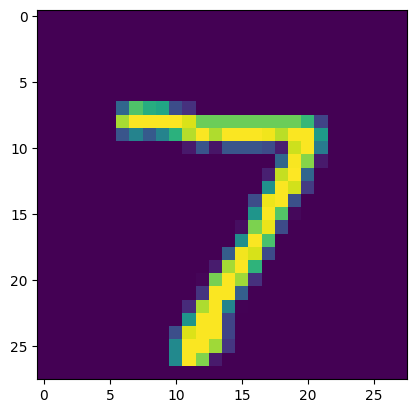

In [10]:
## 2.5 使用 Model.predict 执行推理

# 用 predict 在测试集上对模型进行推理
test_result = model.predict(test_dataset)
# 由于模型是单一输出，test_result的形状为[1, 10000]，10000是测试数据集的数据量。这里打印第一个数据的结果，这个数组表示每个数字的预测概率
print(len(test_result))
print(test_result[0][0])

'''
模型是单一输出：[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n)]
其中每个 numpy_ndarray_n 是对应原始数据经过模型计算后得到的预测结果，类型为 numpy 数组
'''

# 从测试集中取出一张图片
img, label = test_dataset[0]

# 打印推理结果，这里的argmax函数用于取出预测值中概率最高的一个的下标，作为预测标签
pred_label = test_result[0][0].argmax()
print('true label: {}, pred label: {}'.format(label, pred_label))
# 使用matplotlib库，可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0]) # 二维作图，取其中一个通道


In [11]:
# 三、使用基础 API 训练、评估与推理
## 3.1 模型训练（拆解 Model.prepare、Model.fit）
'''
飞桨框架通过基础 API 对模型进行训练，对应高层 API 的 Model.prepare 与 Model.fit ，一般包括如下几个步骤：

加载训练数据集、声明模型、设置模型实例为 train 模式

设置优化器、损失函数与各个超参数

设置模型训练的二层循环嵌套，并在内层循环嵌套中设置如下内容

3.1 从数据读取器 DataLoader 获取一批次训练数据

3.2 执行一次预测，即经过模型计算获得输入数据的预测值

3.3 计算预测值与数据集标签的损失

3.4 计算预测值与数据集标签的准确率

3.5 将损失进行反向传播

3.6 打印模型的轮数、批次、损失值、准确率等信息

3.7 执行一次优化器步骤，即按照选择的优化算法，根据当前批次数据的梯度更新传入优化器的参数

3.8 将优化器的梯度进行清零
'''
# dataset与mnist的定义与使用高层API的内容一致
# 用 DataLoader 实现数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 将mnist模型及其所有子层设置为训练模式。这只会影响某些模块，如 Dropout 和 BatchNorm。
mnist.train()

# 设置迭代次数
epochs = 5

# 设置优化器
optim = paddle.optimizer.Adam(parameters=mnist.parameters())
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
for epoch in range(epochs):
    for batch_id, data in enumerate(train_loader()):
        
        x_data = data[0]            # 训练数据
        y_data = data[1]            # 训练数据标签
        predicts = mnist(x_data)    # 预测结果  
        
        # 计算损失 等价于 prepare 中loss的设置
        loss = loss_fn(predicts, y_data)
        
        # 计算准确率 等价于 prepare 中metrics的设置
        acc = paddle.metric.accuracy(predicts, y_data)
        
        # 下面的反向传播、打印训练信息、更新参数、梯度清零都被封装到 Model.fit() 中
        # 反向传播 
        loss.backward()
        
        if (batch_id+1) % 900 == 0:
            print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id+1, loss.numpy(), acc.numpy()))
        # 更新参数 
        optim.step()
        # 梯度清零
        optim.clear_grad()


epoch: 0, batch_id: 900, loss is: [0.09216936], acc is: [0.953125]
epoch: 1, batch_id: 900, loss is: [0.14373042], acc is: [0.96875]
epoch: 2, batch_id: 900, loss is: [0.13587375], acc is: [0.96875]
epoch: 3, batch_id: 900, loss is: [0.01337348], acc is: [1.]
epoch: 4, batch_id: 900, loss is: [0.16672754], acc is: [0.9375]


In [12]:
## 3.2 模型评估（拆解 Model.evaluate）
'''
加载的数据从训练数据集改为测试数据集

模型实例从 train 模式改为 eval 模式

不需要反向传播、优化器参数更新和优化器梯度清零
'''
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
# 将该模型及其所有子层设置为预测模式。这只会影响某些模块，如Dropout和BatchNorm
mnist.eval()
# 禁用动态图梯度计算
for batch_id, data in enumerate(test_loader()):
    
    x_data = data[0]            # 测试数据
    y_data = data[1]            # 测试数据标签
    predicts = mnist(x_data)    # 预测结果
    
    # 计算损失与精度
    loss = loss_fn(predicts, y_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    
    # 打印信息
    if (batch_id+1) % 30 == 0:
        print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id+1, loss.numpy(), acc.numpy()))


batch_id: 30, loss is: [0.11612443], acc is: [0.953125]
batch_id: 60, loss is: [0.16203663], acc is: [0.9375]
batch_id: 90, loss is: [0.09520508], acc is: [0.984375]
batch_id: 120, loss is: [0.00276513], acc is: [1.]
batch_id: 150, loss is: [0.03584248], acc is: [0.984375]


predict finished
true label: [7], pred label: [7]


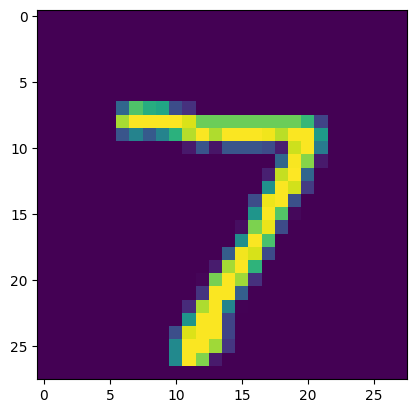

In [21]:
## 3.3 模型推理（拆解 Model.predict）
'''
加载待执行推理的测试数据，并将模型设置为 eval 模式

读取测试数据并获得预测结果

对预测结果进行后处理
'''
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
# 将该模型及其所有子层设置为预测模式
mnist.eval()
for batch_id, data in enumerate(test_loader()):
    # 取出测试数据
    x_data = data[0] 
    # 获取预测结果
    predicts = mnist(x_data)
print("predict finished")

# 从测试集中取出一组数据(一个batch)
img, label = next(test_loader())

# 执行推理并打印结果
pred_label = mnist(img)[0].argmax()
print('true label: {}, pred label: {}'.format(label[0].numpy(), pred_label[0].numpy()))
# 可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0][0])
